In [4]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import torch
from torch import nn
import torch.nn.functional as F

In [5]:
class DQN(nn.Module):
    def __init__(self, in_states, h1_nodes, out_actions):
        super().__init__()
        self.fc1 = nn.Linear(in_states, h1_nodes)
        self.out = nn.Linear(h1_nodes, out_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.out(x)
        return x

class ReplayMemory():
    def __init__(self, maxlen):
        self.memory = deque([], maxlen=maxlen)
    def append(self, transition):
        self.memory.append(transition)
    def sample(self, sample_size):
        return random.sample(self.memory, sample_size)
    def __len__(self):
        return len(self.memory)

# FrozeLake Deep Q-Learning
class FrozenLakeDQL():
    # Hyperparameters (adjustable)
    learning_rate_a = 0.001         # learning rate (alpha)
    discount_factor_g = 0.9         # discount rate (gamma)    
    network_sync_rate = 10          # number of steps the agent takes before syncing the policy and target network
    replay_memory_size = 1000       # size of replay memory
    mini_batch_size = 32            # size of the training data set sampled from the replay memory

    # Neural Network
    loss_fn = nn.MSELoss()          # NN Loss function. MSE=Mean Squared Error can be swapped to something else.
    optimizer = None                # NN Optimizer. Initialize later.

    ACTIONS = ['L','D','R','U']     # for printing 0,1,2,3 => L(eft),D(own),R(ight),U(p)

    # Train the FrozeLake environment
    def train(self, episodes, render=False, is_slippery=False):
        # Create FrozenLake instance
        env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=is_slippery, render_mode='human' if render else None)
        num_states = env.observation_space.n
        num_actions = env.action_space.n
        
        epsilon = 1 # 1 = 100% random actions
        memory = ReplayMemory(self.replay_memory_size)

        # Create policy and target network. Number of nodes in the hidden layer can be adjusted.
        policy_dqn = DQN(in_states=num_states, h1_nodes=num_states, out_actions=num_actions)
        target_dqn = DQN(in_states=num_states, h1_nodes=num_states, out_actions=num_actions)

        # Make the target and policy networks the same (copy weights/biases from one network to the other)
        target_dqn.load_state_dict(policy_dqn.state_dict())

        print('Policy (random, before training):')
        self.print_dqn(policy_dqn)

        # Policy network optimizer. "Adam" optimizer can be swapped to something else. 
        self.optimizer = torch.optim.Adam(policy_dqn.parameters(), lr=self.learning_rate_a)

        # List to keep track of rewards collected per episode. Initialize list to 0's.
        rewards_per_episode = np.zeros(episodes)

        # List to keep track of epsilon decay
        epsilon_history = []

        # Track number of steps taken. Used for syncing policy => target network.
        step_count=0
            
        for i in range(episodes):
            state = env.reset()[0]  # Initialize to state 0
            terminated = False      # True when agent falls in hole or reached goal
            truncated = False       # True when agent takes more than 200 actions    

            # Agent navigates map until it falls into hole/reaches goal (terminated), or has taken 200 actions (truncated).
            while(not terminated and not truncated):

                # Select action based on epsilon-greedy
                if random.random() < epsilon:
                    # select random action
                    action = env.action_space.sample() # actions: 0=left,1=down,2=right,3=up
                else:
                    # select best action            
                    with torch.no_grad():
                        action = policy_dqn(self.state_to_dqn_input(state, num_states)).argmax().item()

                # Execute action
                new_state,reward,terminated,truncated,_ = env.step(action)

                # Save experience into memory
                memory.append((state, action, new_state, reward, terminated)) 

                # Move to the next state
                state = new_state

                # Increment step counter
                step_count+=1

            # Keep track of the rewards collected per episode.
            if reward == 1:
                rewards_per_episode[i] = 1

            # Check if enough experience has been collected and if at least 1 reward has been collected
            if len(memory)>self.mini_batch_size and np.sum(rewards_per_episode)>0:
                mini_batch = memory.sample(self.mini_batch_size)
                self.optimize(mini_batch, policy_dqn, target_dqn)        

                # Decay epsilon
                epsilon = max(epsilon - 1/episodes, 0)
                epsilon_history.append(epsilon)

                # Copy policy network to target network after a certain number of steps
                if step_count > self.network_sync_rate:
                    target_dqn.load_state_dict(policy_dqn.state_dict())
                    step_count=0

        # Close environment
        env.close()

        # Save policy
        torch.save(policy_dqn.state_dict(), "frozen_lake_dql.pt")

        # Create new graph 
        plt.figure(1)

        # Plot average rewards (Y-axis) vs episodes (X-axis)
        sum_rewards = np.zeros(episodes)
        for x in range(episodes):
            sum_rewards[x] = np.sum(rewards_per_episode[max(0, x-100):(x+1)])
        plt.subplot(121) # plot on a 1 row x 2 col grid, at cell 1
        plt.plot(sum_rewards)
        
        # Plot epsilon decay (Y-axis) vs episodes (X-axis)
        plt.subplot(122) # plot on a 1 row x 2 col grid, at cell 2
        plt.plot(epsilon_history)
        
        # Save plots
        plt.savefig('frozen_lake_dql.png')

    # Optimize policy network
    def optimize(self, mini_batch, policy_dqn, target_dqn):

        # Get number of input nodes
        num_states = policy_dqn.fc1.in_features

        current_q_list = []
        target_q_list = []

        for state, action, new_state, reward, terminated in mini_batch:

            if terminated: 
                # Agent either reached goal (reward=1) or fell into hole (reward=0)
                # When in a terminated state, target q value should be set to the reward.
                target = torch.FloatTensor([reward])
            else:
                # Calculate target q value 
                with torch.no_grad():
                    target = torch.FloatTensor(
                        reward + self.discount_factor_g * target_dqn(self.state_to_dqn_input(new_state, num_states)).max()
                    )

            # Get the current set of Q values
            current_q = policy_dqn(self.state_to_dqn_input(state, num_states))
            current_q_list.append(current_q)

            # Get the target set of Q values
            target_q = target_dqn(self.state_to_dqn_input(state, num_states)) 
            # Adjust the specific action to the target that was just calculated
            target_q[action] = target
            target_q_list.append(target_q)
                
        # Compute loss for the whole minibatch
        loss = self.loss_fn(torch.stack(current_q_list), torch.stack(target_q_list))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    '''
    Converts an state (int) to a tensor representation.
    For example, the FrozenLake 4x4 map has 4x4=16 states numbered from 0 to 15. 

    Parameters: state=1, num_states=16
    Return: tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
    '''
    def state_to_dqn_input(self, state:int, num_states:int)->torch.Tensor:
        input_tensor = torch.zeros(num_states)
        input_tensor[state] = 1
        return input_tensor

    # Run the FrozeLake environment with the learned policy
    def test(self, episodes, is_slippery=False):
        # Create FrozenLake instance
        env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=is_slippery, render_mode='human')
        num_states = env.observation_space.n
        num_actions = env.action_space.n

        # Load learned policy
        policy_dqn = DQN(in_states=num_states, h1_nodes=num_states, out_actions=num_actions) 
        policy_dqn.load_state_dict(torch.load("frozen_lake_dql.pt"))
        policy_dqn.eval()    # switch model to evaluation mode

        print('Policy (trained):')
        self.print_dqn(policy_dqn)

        for i in range(episodes):
            state = env.reset()[0]  # Initialize to state 0
            terminated = False      # True when agent falls in hole or reached goal
            truncated = False       # True when agent takes more than 200 actions            

            # Agent navigates map until it falls into a hole (terminated), reaches goal (terminated), or has taken 200 actions (truncated).
            while(not terminated and not truncated):  
                # Select best action   
                with torch.no_grad():
                    action = policy_dqn(self.state_to_dqn_input(state, num_states)).argmax().item()

                # Execute action
                state,reward,terminated,truncated,_ = env.step(action)

        env.close()

    # Print DQN: state, best action, q values
    def print_dqn(self, dqn):
        # Get number of input nodes
        num_states = dqn.fc1.in_features

        # Loop each state and print policy to console
        for s in range(num_states):
            #  Format q values for printing
            q_values = ''
            for q in dqn(self.state_to_dqn_input(s, num_states)).tolist():
                q_values += "{:+.2f}".format(q)+' '  # Concatenate q values, format to 2 decimals
            q_values=q_values.rstrip()              # Remove space at the end

            # Map the best action to L D R U
            best_action = self.ACTIONS[dqn(self.state_to_dqn_input(s, num_states)).argmax()]

            # Print policy in the format of: state, action, q values
            # The printed layout matches the FrozenLake map.
            print(f'{s:02},{best_action},[{q_values}]', end=' ')         
            if (s+1)%4==0:
                print() # Print a newline every 4 states


Policy (random, before training):
00,D,[-0.24 +0.18 +0.05 -0.02] 01,D,[-0.31 +0.24 +0.13 +0.06] 02,D,[-0.32 +0.27 +0.19 +0.03] 03,R,[-0.18 +0.18 +0.19 -0.02] 
04,D,[-0.28 +0.25 +0.06 -0.04] 05,D,[-0.36 +0.33 +0.05 -0.03] 06,D,[-0.26 +0.18 +0.16 +0.07] 07,D,[-0.22 +0.26 +0.06 -0.05] 
08,D,[-0.36 +0.27 +0.16 +0.05] 09,D,[-0.24 +0.21 +0.12 +0.01] 10,D,[-0.35 +0.19 +0.18 -0.03] 11,D,[-0.26 +0.18 +0.15 +0.07] 
12,D,[-0.32 +0.27 +0.18 -0.06] 13,R,[-0.22 +0.18 +0.19 +0.04] 14,D,[-0.38 +0.24 +0.18 +0.11] 15,D,[-0.16 +0.21 +0.17 +0.05] 
Policy (trained):
00,R,[+0.53 +0.59 +0.59 +0.52] 01,R,[+0.53 -0.00 +0.66 +0.57] 02,D,[+0.59 +0.73 +0.59 +0.63] 03,L,[+0.66 +0.10 +0.60 +0.45] 
04,D,[+0.59 +0.66 -0.00 +0.53] 05,D,[+0.41 +0.76 +0.27 +0.51] 06,D,[+0.00 +0.81 +0.00 +0.65] 07,D,[+0.25 +0.55 +0.08 +0.34] 
08,R,[+0.65 -0.00 +0.73 +0.59] 09,R,[+0.66 +0.80 +0.81 +0.09] 10,D,[+0.73 +0.90 +0.00 +0.72] 11,D,[+0.39 +0.48 +0.46 +0.47] 
12,D,[+0.43 +0.82 +0.41 +0.43] 13,R,[+0.23 +0.75 +0.89 +0.52] 14,R,[+0.77

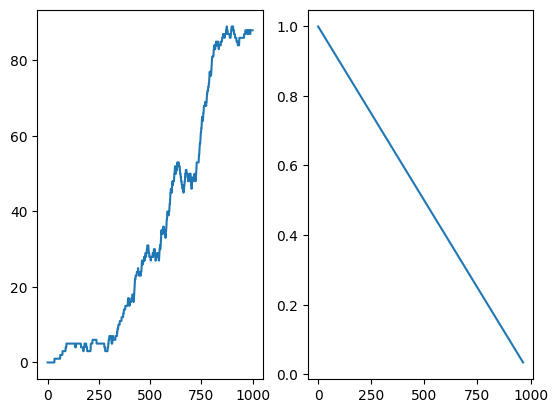

In [6]:
frozen_lake = FrozenLakeDQL()
is_slippery = False
frozen_lake.train(1000, is_slippery=is_slippery)
frozen_lake.test(10, is_slippery=is_slippery)